In [6]:
import os
import warnings
import datetime as dt
import calendar
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import sklearn.linear_model
import sklearn.metrics
import itertools

%pylab inline
pylab.rcParams['figure.figsize'] = (36, 6)

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


Подготовим данные за 6 месяцев (без июня 2016) таким же образом, как мы делали это в задании из первой недели для мая 2016 года.

In [14]:
# Определим координаты Нью-Йорка
new_york_longitude = (-74.25559, -73.70001)
new_york_latitude = (40.49612, 40.91553)

# Загрузим данные о регионах и подготовим бины для 2d гистограммы
regions = pd.read_pickle("../regions.pickle")
binx = regions['west'].append(regions['east']).unique()
biny = regions['south'].append(regions['north']).unique()

# Составим список с комбинациями (год, месяц)
dates = [(2015, 12)]
dates.extend([(2016, x) for x in range(1, 6)])

for (year, month) in dates:
    fname = "yellow_tripdata_" + str(year) + "-" + str(month).zfill(2)
    print "Processing %s..." % fname,
    
    if os.path.isfile("../" + fname + ".pickle"):
        print "already exists"
        continue

    # Загружаем данные за 1 месяц
    data = pd.read_csv("../%s.csv" % fname)
    # Переименуем колонки в старых датасетах
    data.rename(columns={
        ' pickup_datetime': 'tpep_pickup_datetime',
        ' dropoff_datetime': 'tpep_dropoff_datetime',
        ' passenger_count': 'passenger_count',
        ' trip_distance': 'trip_distance',
        ' pickup_longitude': 'pickup_longitude',
        ' pickup_latitude': 'pickup_latitude',
        ' dropoff_longitude': 'dropoff_longitude',
        ' dropoff_latitude': 'dropoff_latitude',
    }, inplace=True)
    data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'])
    data['tpep_dropoff_datetime'] = pd.to_datetime(data['tpep_dropoff_datetime'])
    
    # Проводим фильтрацию
    data.drop(data[data.tpep_dropoff_datetime == data.tpep_pickup_datetime].index, inplace=True)
    data.drop(data[data.passenger_count == 0].index, inplace=True)
    data.drop(data[data.trip_distance == 0].index, inplace=True)
    data.drop(data[(data.pickup_longitude < new_york_longitude[0]) |
                   (data.pickup_longitude > new_york_longitude[1]) |
                   (data.pickup_latitude < new_york_latitude[0]) |
                   (data.pickup_latitude > new_york_latitude[1])].index, inplace=True)
    
    # Отбрасываем минуты и секунды во времени начала поездки
    data['tpep_pickup_datetime'] = data['tpep_pickup_datetime'].apply(lambda x: x.replace(minute = 0, second = 0))
    
    # Посчитаем количество поездок за каждый час из каждой области и сохраним в новый датафрейм,
    # где колонки - номера регионов, а строчки - часы.
    agg2d = stats.binned_statistic_2d(data.pickup_longitude, data.pickup_latitude, None,
                                      'count', bins = [binx, biny], expand_binnumbers=True)
    agg = pd.DataFrame(index = pd.date_range(start = dt.datetime(year, month, 1),
                                             periods = calendar.monthrange(year, month)[1] * 24, freq = '1H'),
                       columns = [i for i in range(1, 2501)],
                       dtype = np.int64)
    agg.fillna(0, inplace=True)
    data['region'] = (agg2d.binnumber[0] - 1) * 50 + agg2d.binnumber[1]
    grouped = data.groupby(['region', 'tpep_pickup_datetime'], as_index=False)
    rides = grouped.size().unstack(level=0, fill_value=0)
    rides.index.name = None
    rides.columns.name = None
    agg.update(rides)
    
    # Сохраним полученный датафрейм для дальнейшего использования
    agg.to_pickle("../%s.pickle" % fname)
    
    print "done"

Processing yellow_tripdata_2015-12... already exists
Processing yellow_tripdata_2016-01... already exists
Processing yellow_tripdata_2016-02... already exists
Processing yellow_tripdata_2016-03... already exists
Processing yellow_tripdata_2016-04... already exists
Processing yellow_tripdata_2016-05... already exists


Создадим временной ряд, объединяющим поездки за 6 месяцев (декабрь 2015 - май 2016) от Empire State Building.

In [15]:
names = ["yellow_tripdata_" + str(year) + "-" + str(month).zfill(2) + ".pickle" for (year, month) in dates]
reg1231 = pd.read_pickle("../" + names[0])[1231]
for n in names[1:]:
    reg1231 = pd.concat([reg1231, pd.read_pickle("../" + n)[1231]])

data = pd.DataFrame(columns=['rides'], index=reg1231.index)
data.rides = reg1231

In [16]:
print data.head()
print data.tail()

                     rides
2015-12-01 00:00:00    394
2015-12-01 01:00:00    185
2015-12-01 02:00:00    109
2015-12-01 03:00:00    100
2015-12-01 04:00:00     92
                     rides
2016-05-31 19:00:00   1094
2016-05-31 20:00:00    997
2016-05-31 21:00:00   1099
2016-05-31 22:00:00    874
2016-05-31 23:00:00    608


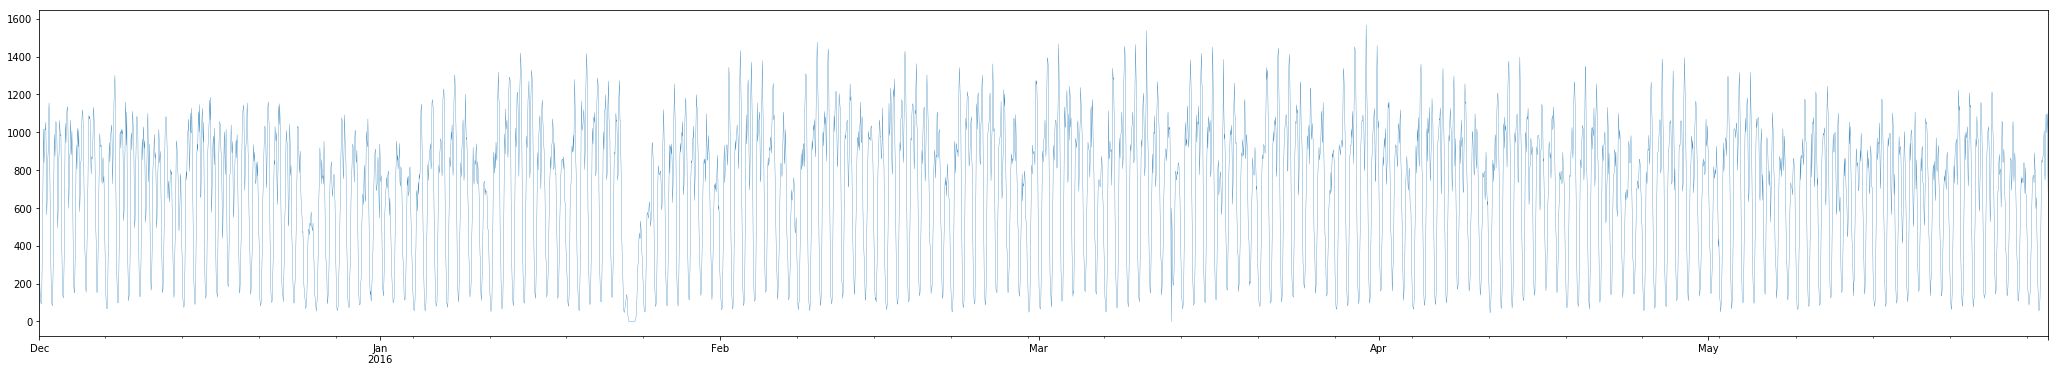

In [17]:
data.rides.plot(linewidth=0.3)

Создадим регрессионные признаки.

In [18]:
K = 150
ex = pd.DataFrame(index=data.index)
ex['lin'] = np.arange(data.shape[0])
ex['const'] = 1.0
for i in range(1, K + 1):
    ex["s%d"%i] = np.sin(np.arange(data.shape[0]) * 2.0 * np.pi * i / 168)
    ex["c%d"%i] = np.cos(np.arange(data.shape[0]) * 2.0 * np.pi * i / 168)

Сделаем регрессию целевой переменной на созданные признаки и посмотрим на остатки.

/usr/local/lib/python2.7/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


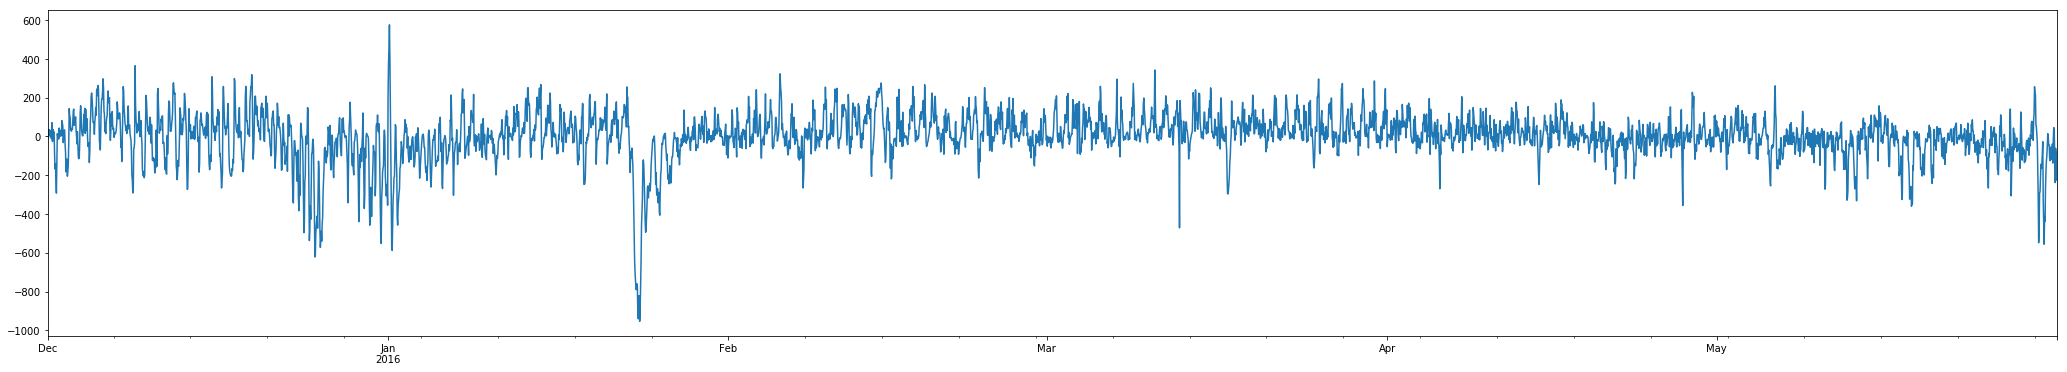

In [19]:
lrm = sklearn.linear_model.LinearRegression()
lrm.fit(ex, data.rides)
data.residuals = data.rides - lrm.predict(ex)
data.residuals.plot()

Видно, что в основном осталась только внутрисуточная сезонность.
Проверим полученный ряд на стационарность и построим его STL-декомпозицию.

Критерий Дики-Фуллера: p=0.000000


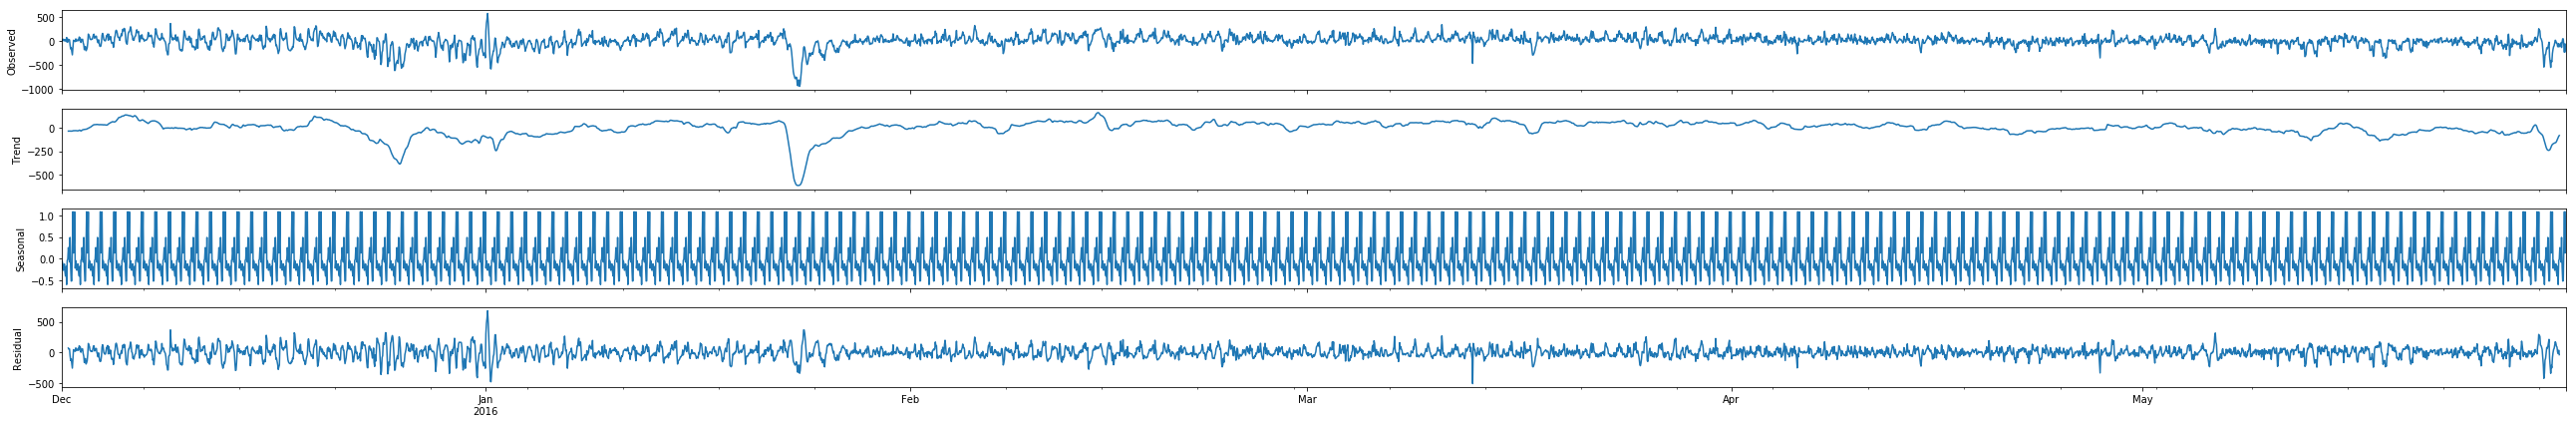

In [20]:
sm.tsa.seasonal_decompose(data.residuals).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.residuals)[1])

В данных просматривается тренд, поэтому попробуем продифференцировать ряд.

Критерий Дики-Фуллера: p=0.000000


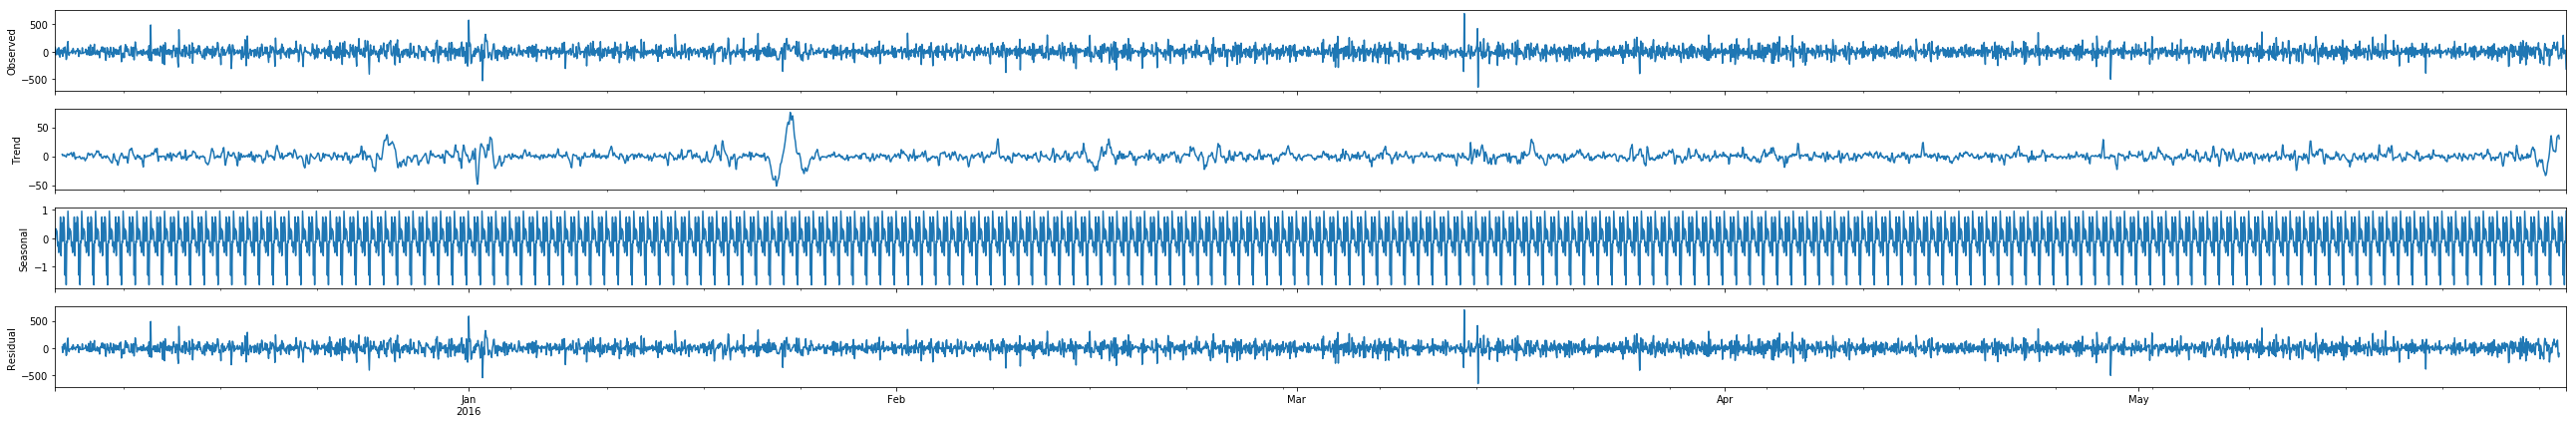

In [21]:
data.residuals_diff = data.residuals - data.residuals.shift(24)
data.residuals_diff2 = data.residuals_diff - data.residuals_diff.shift(1)
sm.tsa.seasonal_decompose(data.residuals_diff2[25:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.residuals_diff2[25:])[1])

Удалось полностью избавиться от тренда.
Построим ACF и PACF ряда остатков.

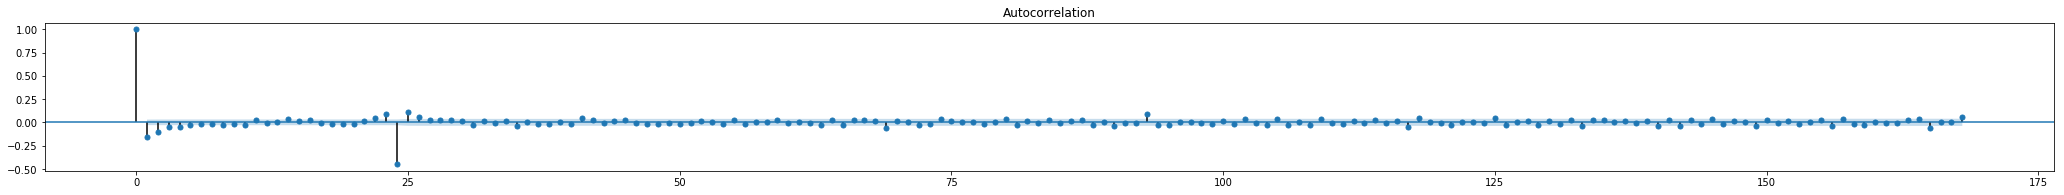

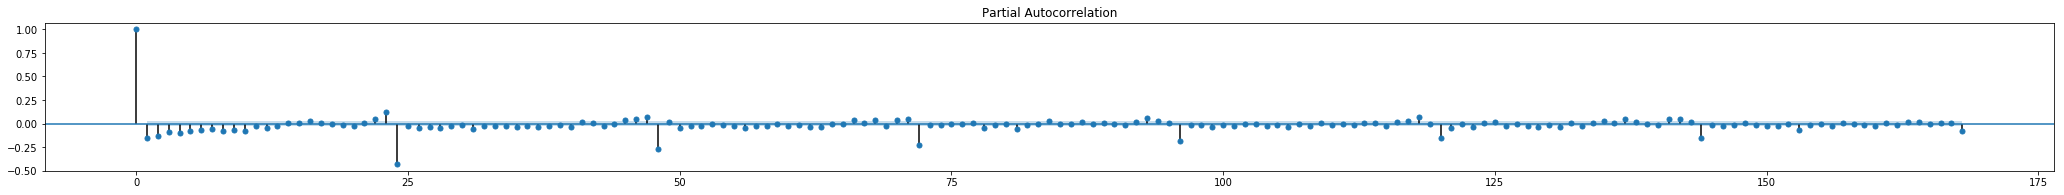

In [22]:
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.residuals_diff2[25:].values.squeeze(), lags=168, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.residuals_diff2[25:].values.squeeze(), lags=168, ax=ax)
pylab.show()

Возьмем следующие приближения:

`
Q = 1
q = 2
P = 3
p = 2
`

In [ ]:
ps = range(0, 3)
d = 1
qs = range(0, 3)
Ps = range(0, 4)
D = 1
Qs = range(0, 2)

parameters = list(itertools.product(ps, qs, Ps, Qs))
print len(parameters)

72


In [ ]:
results = []
best_aic = float("inf")
warnings.filterwarnings("ignore")

for param in parameters:
    print "Trying parameters:", param
    try:
        model = sm.tsa.statespace.SARIMAX(data.rides, exog=ex, order=(param[0], d, param[1]),
                                          seasonal_order=(param[2], D, param[3], 24)).fit(disp=-1)
    except (ValueError, LinAlgError):
        print('wrong parameters:', param)
        continue
    aic = model.aic

    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

warnings.filterwarnings('default')

Trying parameters: (0, 0, 0, 0)
('wrong parameters:', (0, 0, 0, 0))
Trying parameters: (0, 0, 0, 1)
Trying parameters: (0, 0, 1, 0)
Trying parameters: (0, 0, 1, 1)
('wrong parameters:', (0, 0, 1, 1))
Trying parameters: (0, 0, 2, 0)
('wrong parameters:', (0, 0, 2, 0))
Trying parameters: (0, 0, 2, 1)
('wrong parameters:', (0, 0, 2, 1))
Trying parameters: (0, 0, 3, 0)
Trying parameters: (0, 0, 3, 1)
Trying parameters: (0, 1, 0, 0)
Trying parameters: (0, 1, 0, 1)
Trying parameters: (0, 1, 1, 0)
Trying parameters: (0, 1, 1, 1)
Trying parameters: (0, 1, 2, 0)
('wrong parameters:', (0, 1, 2, 0))
Trying parameters: (0, 1, 2, 1)
('wrong parameters:', (0, 1, 2, 1))
Trying parameters: (0, 1, 3, 0)
Trying parameters: (0, 1, 3, 1)
Trying parameters: (0, 2, 0, 0)
Trying parameters: (0, 2, 0, 1)
Trying parameters: (0, 2, 1, 0)
Trying parameters: (0, 2, 1, 1)
Trying parameters: (0, 2, 2, 0)
('wrong parameters:', (0, 2, 2, 0))
Trying parameters: (0, 2, 2, 1)
Trying parameters: (0, 2, 3, 0)
Trying param

In [14]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters           aic
22  (1, 1, 0, 0)  8.593542e+05
4   (0, 1, 0, 0)  1.144621e+07
17  (1, 0, 0, 0)  1.145629e+07
32  (2, 0, 0, 0)  5.712342e+07
10  (0, 2, 0, 0)  7.223294e+07


In [4]:
print best_model.summary()

                                 Statespace Model Results                                 
Dep. Variable:                              rides   No. Observations:                 4392
Model:             SARIMAX(1, 1, 1)x(0, 1, 0, 24)   Log Likelihood             -429372.080
Date:                            Sun, 03 Dec 2017   AIC                         859354.159
Time:                                    13:11:31   BIC                         861302.359
Sample:                                12-01-2015   HQIC                        860041.475
                                     - 05-31-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
lin        -1.656e+07   2.26e-16  -7.32e+22      0.000   -1.66e+07   -1.66e+07
const        1.02e+11        nan   

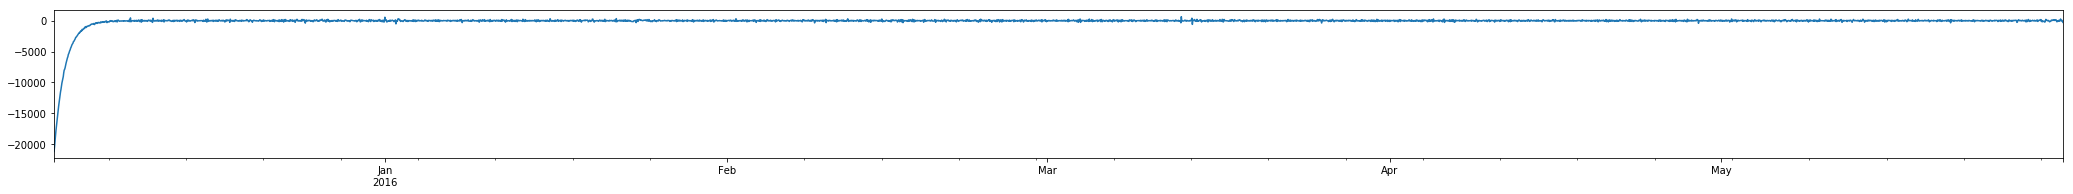

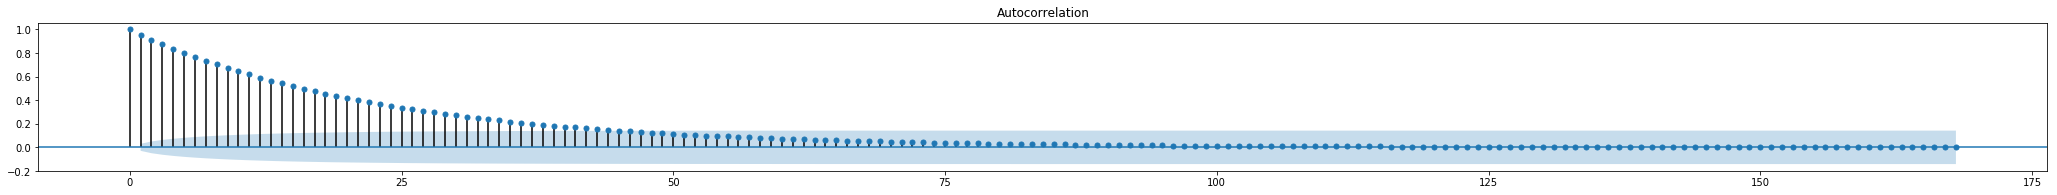

Критерий Стьюдента: p=0.000000
Критерий Дики-Фуллера: p=0.000000


In [30]:
ax = plt.subplot(211)
best_model.resid[25:].plot()
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[25:].values.squeeze(), lags=168, ax=ax)
pylab.show()

print "Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[25:], 0)[1]
print "Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[25:])[1]

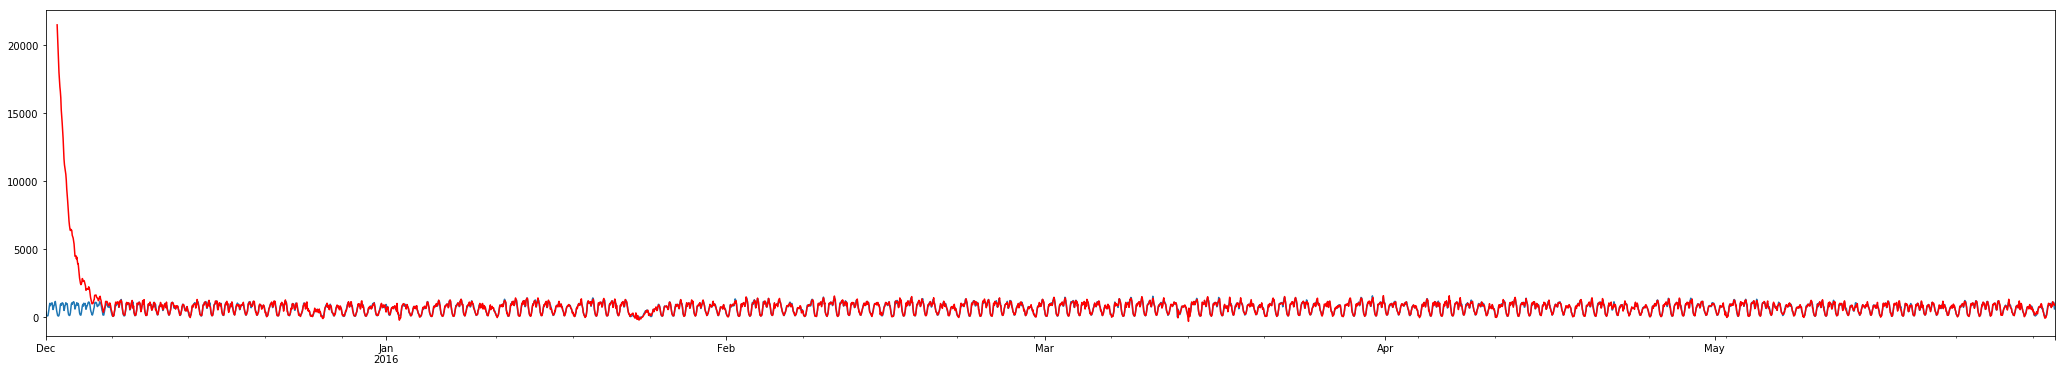

In [32]:
data.rides.plot()
data.model[25:].plot(color='r')

Модель отлично описывает ряд, за исключением первых нескольких дней декабря. К сожалению, не удалось разобраться почему так происходит. Буду благодарен за любые комментарии по этому поводу.